In [ ]:
!pip install keras-cv==0.6.1 keras-core

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.2/756.2 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 944.9/944.9 kB 16.8 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import optimizers
import keras_cv
import numpy as np
from keras_cv import bounding_box
import os
import resource
from keras_cv import visualization
import tqdm

Using TensorFlow backend


In [ ]:
# Get a dictionary pointing from int classes to class names

class_ids = [
    "Aeroplane",
    "Bicycle",
    "Bird",
    "Boat",
    "Bottle",
    "Bus",
    "Car",
    "Cat",
    "Chair",
    "Cow",
    "Dining Table",
    "Dog",
    "Horse",
    "Motorbike",
    "Person",
    "Potted Plant",
    "Sheep",
    "Sofa",
    "Train",
    "Tvmonitor",
    "Total",
]
class_mapping = dict(zip(range(len(class_ids)), class_ids))

In [ ]:
class_mapping

{0: 'Aeroplane',
 1: 'Bicycle',
 2: 'Bird',
 3: 'Boat',
 4: 'Bottle',
 5: 'Bus',
 6: 'Car',
 7: 'Cat',
 8: 'Chair',
 9: 'Cow',
 10: 'Dining Table',
 11: 'Dog',
 12: 'Horse',
 13: 'Motorbike',
 14: 'Person',
 15: 'Potted Plant',
 16: 'Sheep',
 17: 'Sofa',
 18: 'Train',
 19: 'Tvmonitor',
 20: 'Total'}

In [ ]:
BATCH_SIZE = 4

In [ ]:
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )

In [ ]:
# https://keras.io/api/keras_cv/bounding_box/formats/#rel_xyxy-class
def unpackage_raw_tfds_inputs(inputs, bounding_box_format):
    image = inputs["image"]
    boxes = keras_cv.bounding_box.convert_format(
        inputs["objects"]["bbox"],
        images=image,
        source="rel_yxyx",
        target=bounding_box_format,
    )
    bounding_boxes = {
        "classes": tf.cast(inputs["objects"]["label"], dtype=tf.float32),
        "boxes": tf.cast(boxes, dtype=tf.float32),
    }
    return {
        "images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes
    }

In [ ]:
def load_pascal_voc(split, dataset, bounding_box_format):
    ds = tfds.load(dataset, split=split, with_info=False, shuffle_files=True)
    ds = ds.map(
        lambda x: unpackage_raw_tfds_inputs(
            x, bounding_box_format=bounding_box_format),
        num_parallel_calls=tf.data.AUTOTUNE,
    )
    return ds

In [ ]:
train_ds = load_pascal_voc(
    split="train", dataset="voc/2007", bounding_box_format="xywh"
)
eval_ds = load_pascal_voc(
    split="test", dataset="voc/2007", bounding_box_format="xywh"
)

train_ds = train_ds.shuffle(BATCH_SIZE * 4)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating test examples...:   0%|          | 0/4952 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/voc/2007/4.0.0.incompleteIVI2FA/voc-test.tfrecord*...:   0%|          | 0/…

Generating train examples...:   0%|          | 0/2501 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/voc/2007/4.0.0.incompleteIVI2FA/voc-train.tfrecord*...:   0%|          | 0…

Generating validation examples...:   0%|          | 0/2510 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/voc/2007/4.0.0.incompleteIVI2FA/voc-validation.tfrecord*...:   0%|        …

Dataset voc downloaded and prepared to /root/tensorflow_datasets/voc/2007/4.0.0. Subsequent calls will reuse this data.


In [ ]:
# We use ragged batch since images can be of different sizes
# and each image can have variable number of objects

train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
eval_ds = eval_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)

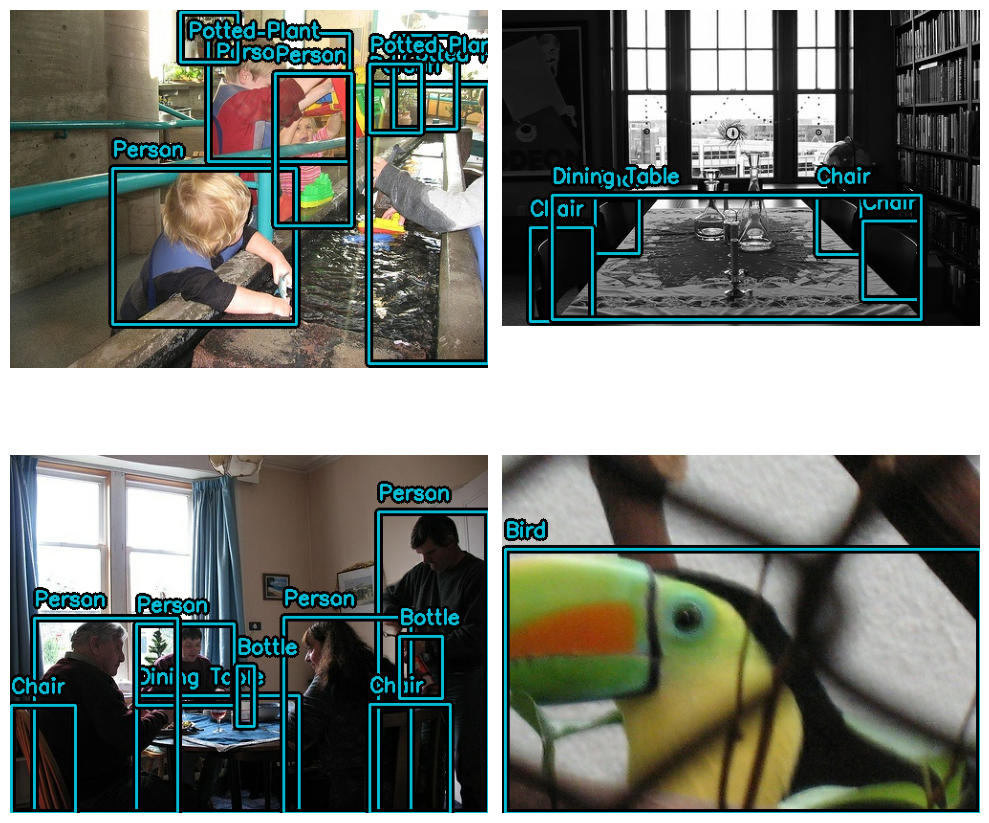

In [ ]:
# Visualize the dataset to ensure bounding boxes are in the right place
# with correct labels. If done incorrectly, bounding boxes will not appear
# or they will be in the wrong place.

visualize_dataset(
    train_ds, bounding_box_format="xywh", value_range=(0, 255), rows=2, cols=2
)

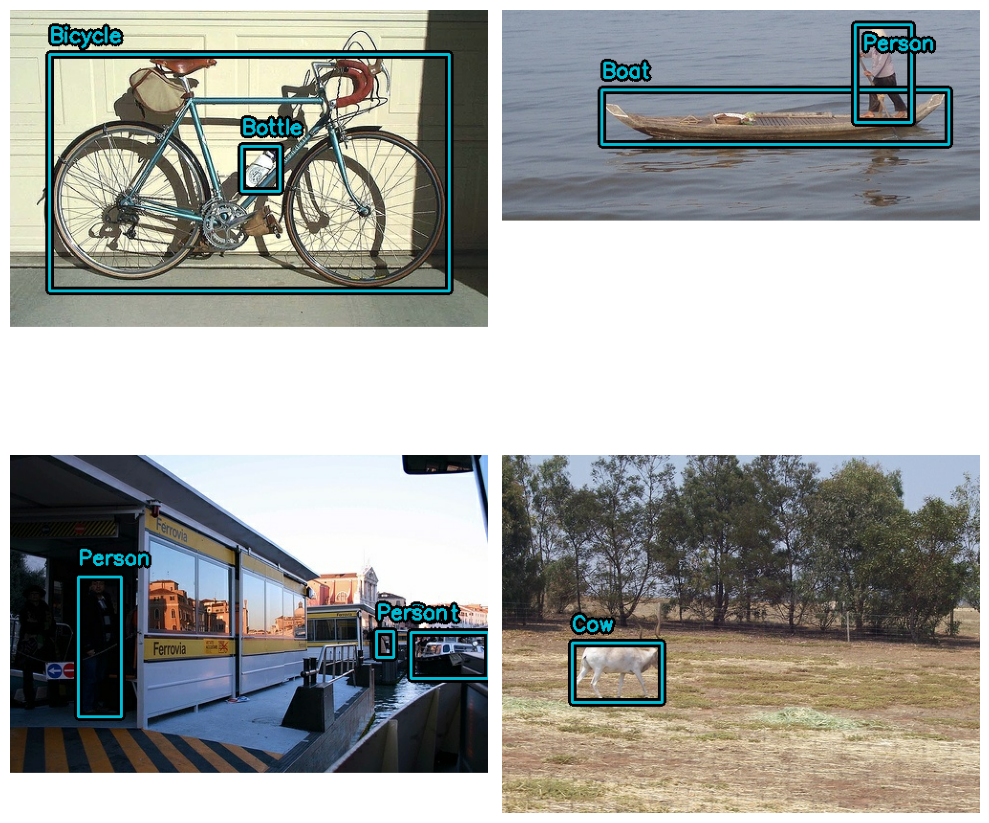

In [ ]:
# Visualize validation set
visualize_dataset(
    eval_ds,
    bounding_box_format="xywh",
    value_range=(0, 255),
    rows=2,
    cols=2,
)

In [ ]:
# Data augmentation is complex since after the image is modified, the bounding
# boxes must also be modified accordingly!
augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(
            mode="horizontal",
            bounding_box_format="xywh"),
        keras_cv.layers.JitteredResize(
            target_size=(640, 640),
            scale_factor=(0.75, 1.3),
            bounding_box_format="xywh"
        ),
    ]
)

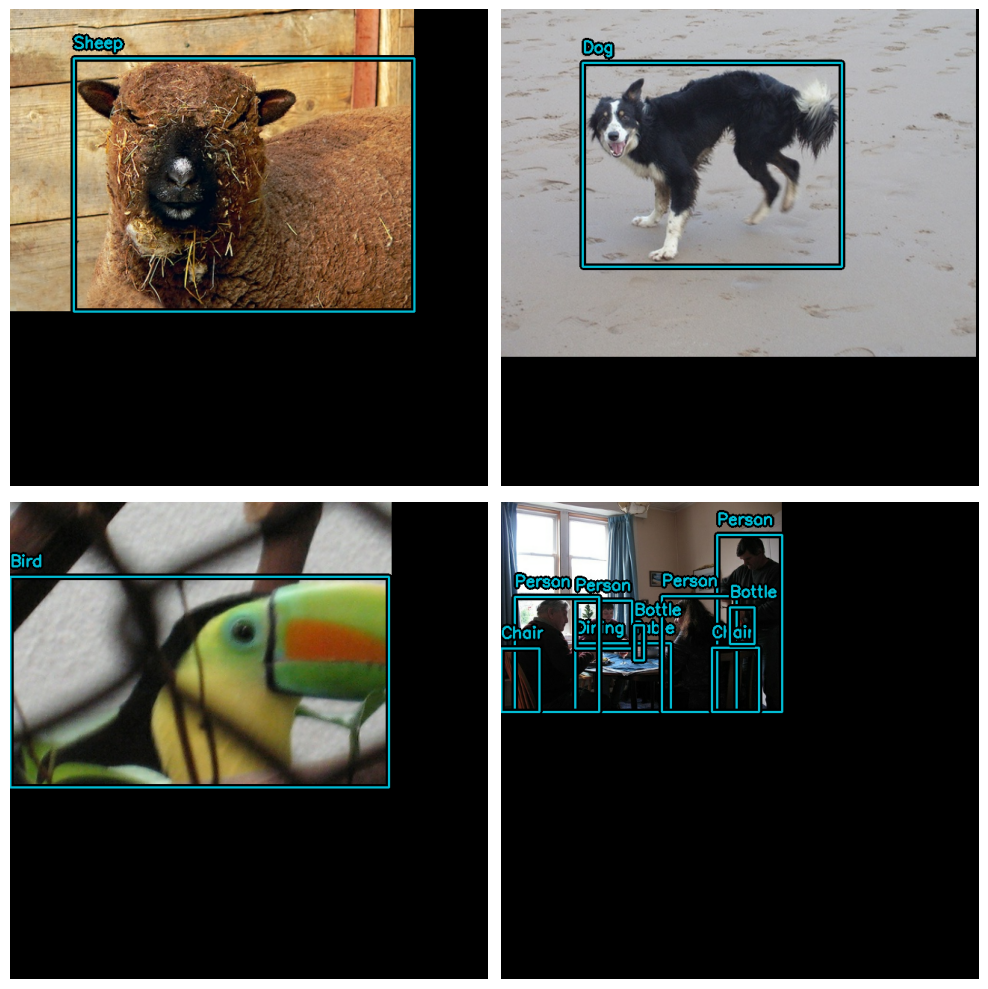

In [ ]:
train_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)
visualize_dataset(
    train_ds, bounding_box_format="xywh", value_range=(0, 255), rows=2, cols=2
)

In [ ]:
# Let's use deterministic resizing for the validation set

inference_resizing = keras_cv.layers.Resizing(
    640, 640, bounding_box_format="xywh", pad_to_aspect_ratio=True
)
eval_ds = eval_ds.map(inference_resizing, num_parallel_calls=tf.data.AUTOTUNE)

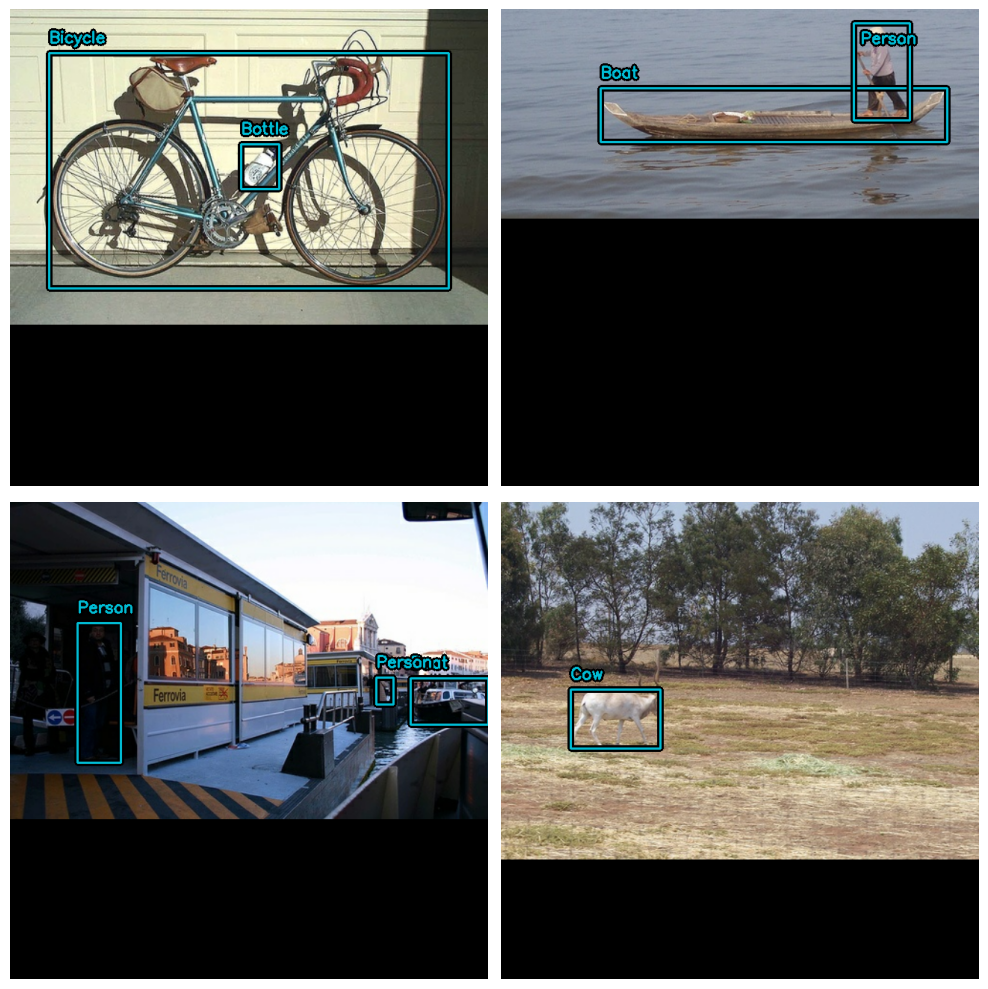

In [ ]:
# Let's make sure the resizing worked

visualize_dataset(
    eval_ds, bounding_box_format="xywh", value_range=(0, 255), rows=2, cols=2
)

In [ ]:
# This is the final form our model expects:
# tuple of (images, bounding_box_dictionary)
# to_dense() makes the batch compatible with TPU

def dict_to_tuple(inputs):
    return inputs["images"], bounding_box.to_dense(
        inputs["bounding_boxes"], max_boxes=32
    )

In [ ]:
train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
eval_ds = eval_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)

train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
eval_ds = eval_ds.prefetch(tf.data.AUTOTUNE)

In [ ]:
# Global clipnorm helps to reduce exploding gradient

base_lr = 0.005
# including a global_clipnorm is extremely important in object detection tasks
optimizer = tf.keras.optimizers.SGD(
    learning_rate=base_lr, momentum=0.9, global_clipnorm=10.0
)

In [ ]:
# Creates a "RetinaNet" from ResNet50 backbone

model = keras_cv.models.RetinaNet.from_preset(
    "resnet50_imagenet",
    num_classes=len(class_mapping),
    bounding_box_format="xywh",
)

94657128/94657128 [==============================] - 5s 0us/step


In [ ]:
model.compile(
    classification_loss="focal",
    box_loss="smoothl1",
    optimizer=optimizer,
)

In [ ]:
# Remove take(20) for full training (takes very long!)
model.fit(
    train_ds.take(20),
    validation_data=eval_ds.take(20),
    epochs=10,
)

Epoch 1/10
20/20 [==============================] - 58s 896ms/step - loss: 1.8156 - box_loss: 0.6968 - classification_loss: 1.1188 - percent_boxes_matched_with_anchor: 0.9203 - val_loss: 1.7650 - val_box_loss: 0.6925 - val_classification_loss: 1.0725 - val_percent_boxes_matched_with_anchor: 0.9004
Epoch 2/10
20/20 [==============================] - 16s 788ms/step - loss: 1.6249 - box_loss: 0.6678 - classification_loss: 0.9571 - percent_boxes_matched_with_anchor: 0.9148 - val_loss: 2.6183 - val_box_loss: 0.6803 - val_classification_loss: 1.9380 - val_percent_boxes_matched_with_anchor: 0.9176
Epoch 3/10
20/20 [==============================] - 15s 754ms/step - loss: 1.4786 - box_loss: 0.6492 - classification_loss: 0.8294 - percent_boxes_matched_with_anchor: 0.9187 - val_loss: 212.2351 - val_box_loss: 0.6698 - val_classification_loss: 211.5652 - val_percent_boxes_matched_with_anchor: 0.9086
Epoch 4/10
20/20 [==============================] - 15s 747ms/step - loss: 1.3721 - box_loss: 0.613

In [ ]:
# Let's load a fully trained model to test predictions
model = keras_cv.models.RetinaNet.from_preset(
    "retinanet_resnet50_pascalvoc", bounding_box_format="xywh"
)

# construct a dataset with larger batches:
visualization_ds = eval_ds.unbatch()
visualization_ds = visualization_ds.ragged_batch(16)
visualization_ds = visualization_ds.shuffle(8)

142662880/142662880 [==============================] - 1s 0us/step


In [ ]:
def visualize_detections(model, dataset, bounding_box_format):
    images, y_true = next(iter(dataset.take(1)))
    y_pred = model.predict(images)
    y_pred = bounding_box.to_ragged(y_pred)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=4,
        rows=4,
        cols=2,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )

In [ ]:
# Set IoU and confidence threshold
model.prediction_decoder = keras_cv.layers.MultiClassNonMaxSuppression(
    bounding_box_format="xywh",
    from_logits=True,
    iou_threshold=0.5,
    confidence_threshold=0.5,
)

1/1 [==============================] - 49s 49s/step


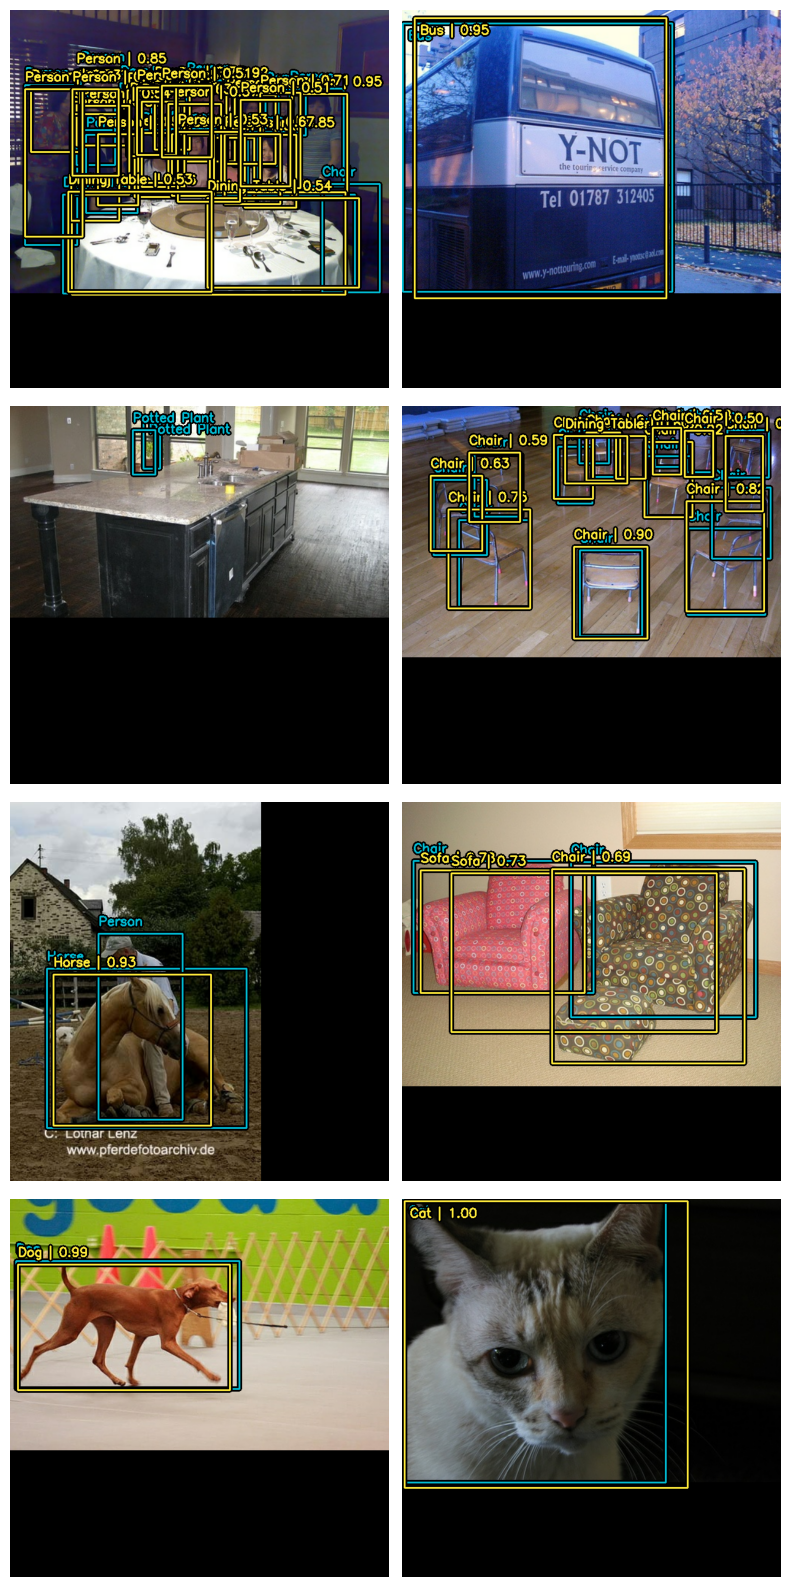

In [ ]:
visualize_detections(model, dataset=visualization_ds, bounding_box_format="xywh")

![](https://deeplearningcourses.com/notebooks_v3_pxl?sc=nLHaQhsbus-2qJNJREKg8w&n=Train+Object+Detection+Simple)